# MAIN ANALYSIS NOTEBOOK FOR PAPER CONTENT

In [1]:
# environment setupa
import os
from matplotlib import pyplot as plt
import pandas as pd
from openbabel import openbabel as ob
from scipy import stats
from scipy.stats import norm, pearsonr
import numpy as np
import utils
from featurizers import StructurePropertyFeaturizer
from read_to_sql import StructureProperty, Substituent, Structure
# creating session with SQL database
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
engine = create_engine("sqlite:///{}".format(os.environ("CRYSTAL_MAIN_DB")))
session = sessionmaker(bind=engine)()
utils.define_pallet()

In [2]:
# setting up important global variables & functions

def non_planarity_modes(session):
    names = session.query(StructureProperty.property).distinct().all()
    return [x[0] for x in names if "non planarity" in x[0]]

def homa_properties(session, target="homa"):
    names = session.query(StructureProperty.property).filter(StructureProperty.source == "homa").distinct().all()
    return [x[0] for x in names if target in x[0]]

def homa_values_df(session, sids, target, avg_pyrroles):
    # reading the data from SQL
    homa_props = homa_properties(session, target=target)
    units = [None for _ in range(len(homa_props))]
    feat = StructurePropertyFeaturizer(homa_props, units, navalue=None)
    homa_df = pd.DataFrame(data=feat.featurize(session, sids), columns=feat.feature_names, index=sids)
    homa_df.columns = [c.split(" ")[0] for c in homa_df.columns]
    if avg_pyrroles:
        # adding column of average pyrrole HOMA score
        pyrrole_cols = [c for c in homa_df.columns if "pyrrole" in c]
        homa_df["pyrrole_avg"] = homa_df[pyrrole_cols].mean(axis=1)
        # removing all other pyrrole columns
        # homa_df = homa_df[[c for c in homa_df.columns if not c in pyrrole_cols]]
    return homa_df

def non_planarity_df(session, sids, units, add_total_non_planarity):
    # reading the data
    modes = non_planarity_modes(session)
    # removing wavingy2 mode as it exists only in corroles
    modes.remove("wavingy2 non planarity")
    mode_units = [units for _ in range(len(modes))]
    if add_total_non_planarity:
        modes.append("total out of plane (exp)")
        mode_units.append("A")
    feat = StructurePropertyFeaturizer(modes, mode_units, navalue=None)
    return pd.DataFrame(data=feat.featurize(session, sids), columns=feat.feature_names, index=sids)

def scatter_plot(x, y, ax=None, xname=None, yname=None, add_fitted_line=False, add_ideal_line=False, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, label=label)
    if xname is not None:
        ax.set_xlabel(xname)
    if yname is not None:
        ax.set_ylabel(yname)
    if add_fitted_line:
        a, b = np.polyfit(x, y, deg=1)
        fitted_x = [min(x), max(x)]
        fitted_y = [a * v + b for v in fitted_x]
        ax.plot(fitted_x, fitted_y, "r--")
    if add_ideal_line:
        fitted_x = [min(x), max(x)]
        ax.plot(fitted_x, fitted_x, "r--")

def p_value(sample_data, population_data):
    """Calculate the p-value of sample from normal distribution. calculates the probability that the mean difference between the sample and the population is at least as large as measured."""
    sample_mean = np.mean(sample_data)
    population_mean = np.mean(population_data)
    population_std = np.std(population_data)
    N = len(sample_data)
    statistic = abs((sample_mean - population_mean) / (population_std / np.sqrt(N)))
    return 2 * norm(0, 1).sf(statistic)

def metal_radius(session, sid: int):
    """Get the VDW radius of the metal center"""
    metal = session.query(Substituent.substituent).filter(Substituent.structure == sid).filter(Substituent.position == "metal").all()[0][0]
    metal = utils.mol_from_smiles(metal).GetAtom(1)
    return [ob.GetVdwRad(metal.GetAtomicNum())]

def pie_chart(infodict: dict, figsize=(6, 3), fontsize=12):
    """Plot a pie chart given a dictionary with category -> value mapping"""
    categories = list(infodict.keys())
    counts = list(infodict.values())
    plt.figure(figsize=figsize)
    wedges, texts = plt.pie(counts, wedgeprops=dict(width=0.5), startangle=-40)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center", fontsize=fontsize)

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate("{} ({})".format(categories[i].title(), counts[i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

# Basic analysis

Analyzing basic structure statistics


N metals 22


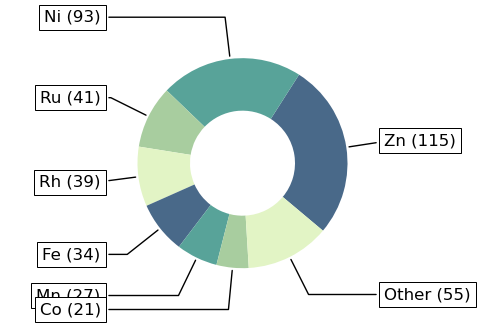

In [3]:
# getting the central metal distrubution - getting a counter dict of central metals
por_sids = utils.sids_by_type(session, "porphyrin")
central_metal_smiles = session.query(Substituent.substituent).filter(Substituent.position == "metal").filter(Substituent.structure.in_(por_sids)).all()
central_metal_smiles = [c[0][1:-1] for c in central_metal_smiles]
central_metal_count = {}
for m in central_metal_smiles:
    if m in central_metal_count:
        central_metal_count[m] += 1
    else:
        central_metal_count[m] = 1
# fabulizing counter dict
df = pd.DataFrame(central_metal_count.values(), index=central_metal_count.keys(), columns=["count"])
df = df.sort_values("count", ascending=False)
print("N metals", len(df))
th = 15
counter_df = df[df["count"] >= th]
other_count = df[df["count"] < th].sum()
counter_df = pd.concat([counter_df, pd.DataFrame([other_count], index=["other"], columns=["count"])])
infodict = counter_df.to_dict()["count"]
pie_chart(infodict, figsize=(6, 3), fontsize=12)

442


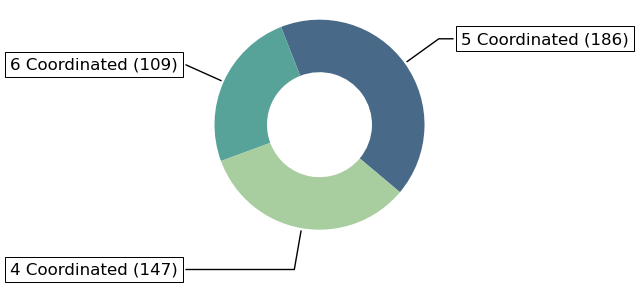

In [4]:
# getting the coordination number distribution
axial_ligand_count = session.query(func.count(Substituent.id)).\
                        filter(Substituent.position == "axial").\
                        filter(Substituent.structure.in_(por_sids)).group_by(Substituent.structure).all()
axial_ligand_count = [c[0] for c in axial_ligand_count]
# making a counter dict
infodict = {}
for v in axial_ligand_count:
    k = "{} Coordinated".format(4 + v)
    if k in infodict:
        infodict[k] += 1
    else:
        infodict[k] = 1
# accounting for 4 coordinated structures
n_structures = session.query(Structure).count()
infodict["{} Coordinated".format(4)] = n_structures - len(axial_ligand_count)
print(n_structures)
pie_chart(infodict)

Text(0.5, 1.0, 'Molecular Weight (gr/mol)')

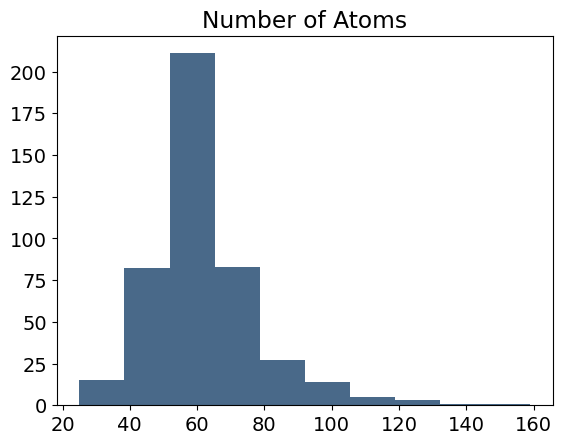

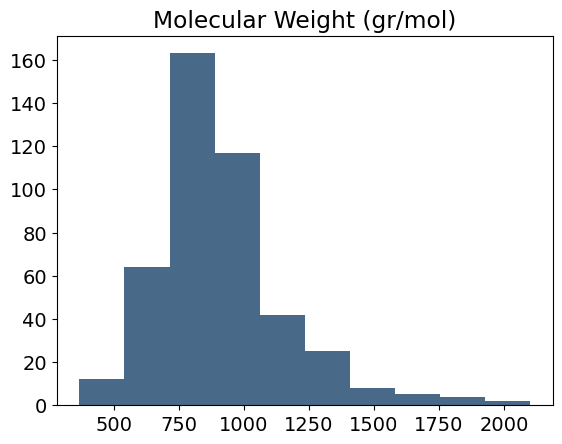

In [5]:
# getting the molecular size distribution
smiles = session.query(Structure.smiles).all()
mols = [utils.mol_from_smiles(c[0]) for c in smiles]
natoms = [mol.NumAtoms() for mol in mols]
molmass = [mol.GetMolWt() for mol in mols]
# making histograms
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# plt.tight_layout()
plt.figure()
plt.hist(natoms)
plt.title("Number of Atoms")
plt.figure()
plt.hist(molmass)
plt.title("Molecular Weight (gr/mol)")

    count
0       4
1       2
2       8
3      23
4     280
5       8
6       7
7       3
8      46
9      14
10     10
11      3
12     34


Text(0, 0.5, 'Count')

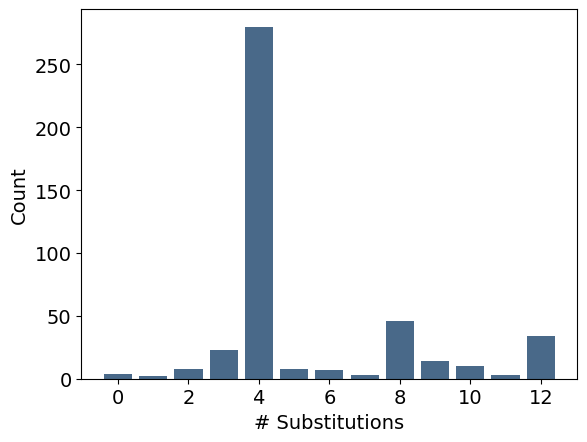

In [6]:
# generating hydrogen counter plot
nhydrogens = session.query(func.count(Substituent.id)).filter(Substituent.substituent == "[*H]").group_by(Substituent.structure).all()
# nhydrogens = session.query(func.count(Substituent.id)).filter(Substituent.substituent == "[*H]").filter(Substituent.position == "beta").group_by(Substituent.structure).all()
nhydrogens = [c[0] for c in nhydrogens]
# making a counter dict
infodict = {}
for v in nhydrogens:
    if v in infodict:
        infodict[v] += 1
    else:
        infodict[v] = 1
df = pd.DataFrame(infodict.values(), index=infodict.keys(), columns=["count"])
df.index = df.index.max() - df.index
# adding the 12 substituted option (no hydrogens at all)
df = pd.concat([df, pd.DataFrame([n_structures - df["count"].sum()], index=[df.index.max() + 1], columns=["count"])])
df = df.sort_index()
print(df)
plt.bar(df.index, height=df["count"], width=0.8)
plt.xlabel("# Substitutions")
plt.ylabel("Count")

In [7]:
# generating hydrogen counter plot
beta = session.query(Substituent.structure, func.count(Substituent.id)).filter(Substituent.substituent == "[*H]").filter(Substituent.structure.in_(por_sids)).\
    filter(Substituent.position == "beta").\
    group_by(Substituent.structure).all()
meta = session.query(Substituent.structure, func.count(Substituent.id)).filter(Substituent.substituent == "[*H]").filter(Substituent.structure.in_(por_sids)).\
    filter((Substituent.position == "meso") | (Substituent.position == "meta")).\
    group_by(Substituent.structure).all()
sids = utils.sids_by_type(session, "porphyrin")
df = pd.DataFrame([], index=sids)
beta = pd.DataFrame(beta, columns=["sid", "beta"])
beta = beta.set_index("sid")
meta = pd.DataFrame(meta, columns=["sid", "meta"])
meta = meta.set_index("sid")
df = pd.merge(df, beta, right_index=True, left_index=True, how="left")
df = pd.merge(df, meta, right_index=True, left_index=True, how="left")
# fabulizing
df = df.fillna(0)
df["beta"] = 8 - df["beta"]
df["meta"] = 4 - df["meta"]
df["count"] = 1
grouped = df.groupby(["beta", "meta"]).sum()
grouped["%"] = round(grouped["count"] / len(sids) * 100, 2)
print(grouped)
grouped.to_csv("subtitutions_counter.csv")

           count      %
beta meta              
0.0  0.0       4   0.94
     1.0       2   0.47
     2.0       8   1.88
     3.0      23   5.41
     4.0     265  62.35
1.0  3.0       1   0.24
     4.0       5   1.18
2.0  3.0       2   0.47
     4.0       6   1.41
3.0  4.0       3   0.71
4.0  1.0       1   0.24
     4.0      10   2.35
5.0  1.0       1   0.24
     4.0       1   0.24
6.0  4.0       3   0.71
7.0  4.0       1   0.24
8.0  0.0      35   8.24
     1.0      13   3.06
     2.0       6   1.41
     3.0       2   0.47
     4.0      33   7.76


Analyzing basic corrleations and properties

In [8]:
por_sids = utils.sids_by_type(session, "porphyrin")
por_homa = homa_values_df(session, por_sids, "homa", True)
por_en = homa_values_df(session, por_sids, "en", True)
por_geo = homa_values_df(session, por_sids, "geo", True)

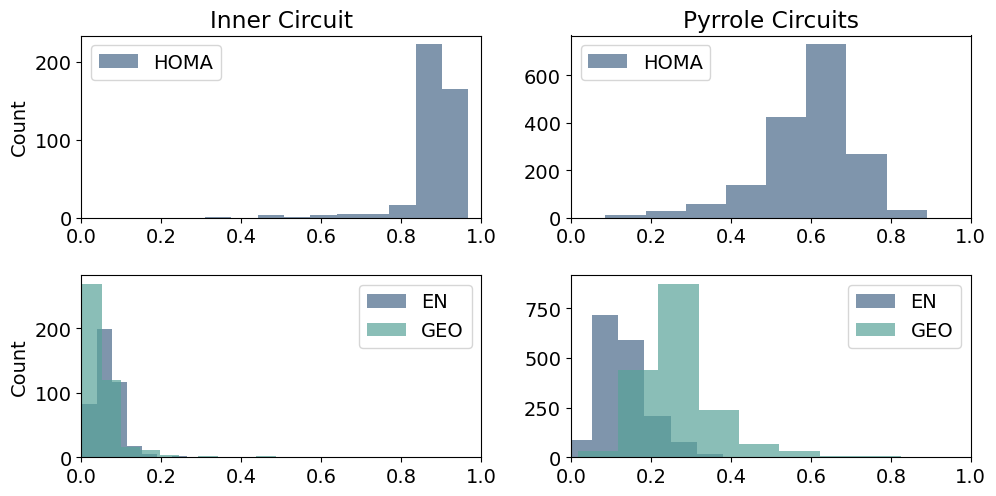

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.tight_layout()

def draw_values(i, j, values, title=None, label=None):
    axs[i, j].hist(values, density=False, alpha=0.7, label=label)
    if not title is None:
        axs[i, j].set_title(title)
    # axs[i, j].set_xlabel("Value")
    # axs[i, j].set_ylabel("Count (normalized)")
    axs[i, j].set_xlim(0, 1)
    if label is not None:
        axs[i, j].legend()
    if j == 0:
        axs[i, j].set_ylabel("Count")

# draw HOMA
draw_values(0, 0, por_homa["inner_circuit"], "Inner Circuit", label="HOMA")
draw_values(0, 1, por_homa[[c for c in por_homa.columns if "pyrrole" in c and not c == "pyrrole_avg"]].values.flatten(), "Pyrrole Circuits", label="HOMA")
# draw EN + GEO
draw_values(1, 0, por_en["inner_circuit"], label="EN")
draw_values(1, 0, por_geo["inner_circuit"], label="GEO")
draw_values(1, 1, por_en[[c for c in por_homa.columns if "pyrrole" in c and not c == "pyrrole_avg"]].values.flatten(), label="EN")
draw_values(1, 1, por_geo[[c for c in por_homa.columns if "pyrrole" in c and not c == "pyrrole_avg"]].values.flatten(), label="GEO")

## Non-Planarity

In [10]:
por_abs_np = non_planarity_df(session, por_sids, "A", add_total_non_planarity=True)
dominant_modes = non_planarity_df(session, por_sids, "%", add_total_non_planarity=True)

In [11]:
npor = sum(por_abs_np["total out of plane (exp)"] > 0.7)
print("N NON PLANAR PORPHYRINS", npor, "({:.2f})".format(npor / len(por_abs_np)))

N NON PLANAR PORPHYRINS 192 (0.45)


Text(0, 0.5, 'Count')

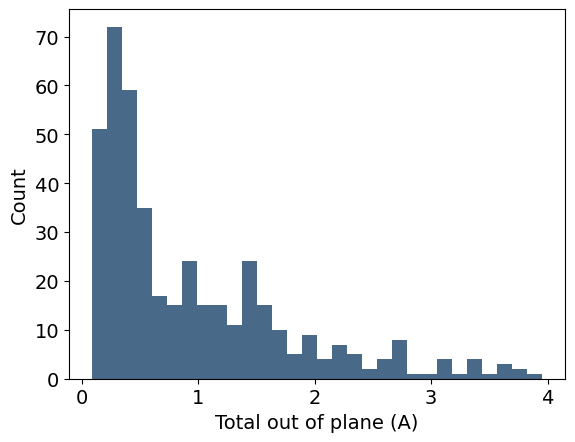

In [12]:
plt.hist(por_abs_np["total out of plane (exp)"], bins=30, density=False, label="porphyrins", alpha=1)
# plt.vlines([0.7], *plt.ylim(), colors="k", linestyles="--", label="Non planarity limit")
plt.xlabel("Total out of plane (A)")
plt.ylabel("Count")

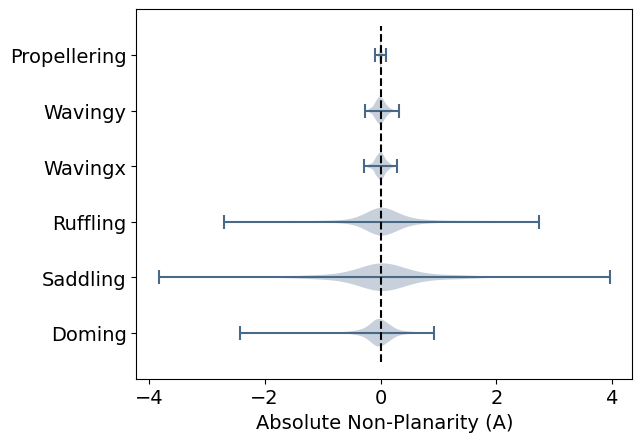

In [13]:
plt.figure()
pdf = por_abs_np[[c for c in por_abs_np.columns if not "2" in c and not "total" in c]]
plt.yticks(range(1, len(pdf.columns) + 1), [c.split()[0].title() for c in pdf.columns])
plt.violinplot(pdf, vert=False)
plt.xlabel("Absolute Non-Planarity (A)")
plt.vlines([0], *plt.ylim(), linestyles="--", colors="k")


dominant mode calculation - DO NOT USE FOR PAPER

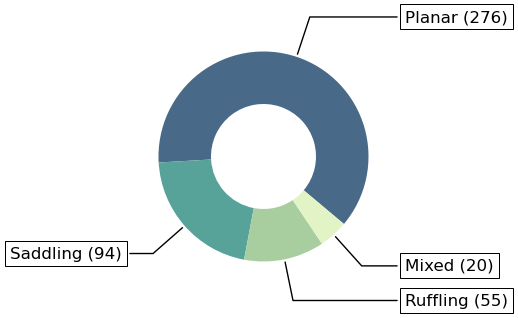

In [14]:
dominant_modes_df = []
ajr = {"planar": 0, "mixed": 0}
mode_cols = [c for c in dominant_modes.columns if not "total" in c]
for sid in dominant_modes.index:
    if dominant_modes.loc[sid, "total out of plane (exp)"] > 1:
        mode = dominant_modes.loc[sid, mode_cols].idxmax()
        if dominant_modes.loc[sid, mode] < 50:
            ajr["mixed"] += 1
        mode = mode.split()[0]
        if mode not in ajr:
            ajr[mode] = 1
        else:
            ajr[mode] += 1
    else:
        ajr["planar"] += 1
# fabulizing counter dict
df = pd.DataFrame(ajr.values(), index=ajr.keys(), columns=["count"])
df = df.sort_values("count", ascending=False)
# th = 15
# counter_df = df[df["count"] >= th]
# other_count = df[df["count"] < th].sum()
# df = pd.concat([counter_df, pd.DataFrame([other_count], index=["other"], columns=["count"])])
infodict = df.to_dict()["count"]
pie_chart(infodict)

basic analysis of non planarity metrics vs. HOMA score

inner_circuit a = -0.0012527642996782256
pyrrole_avg a = -0.016098208072849368


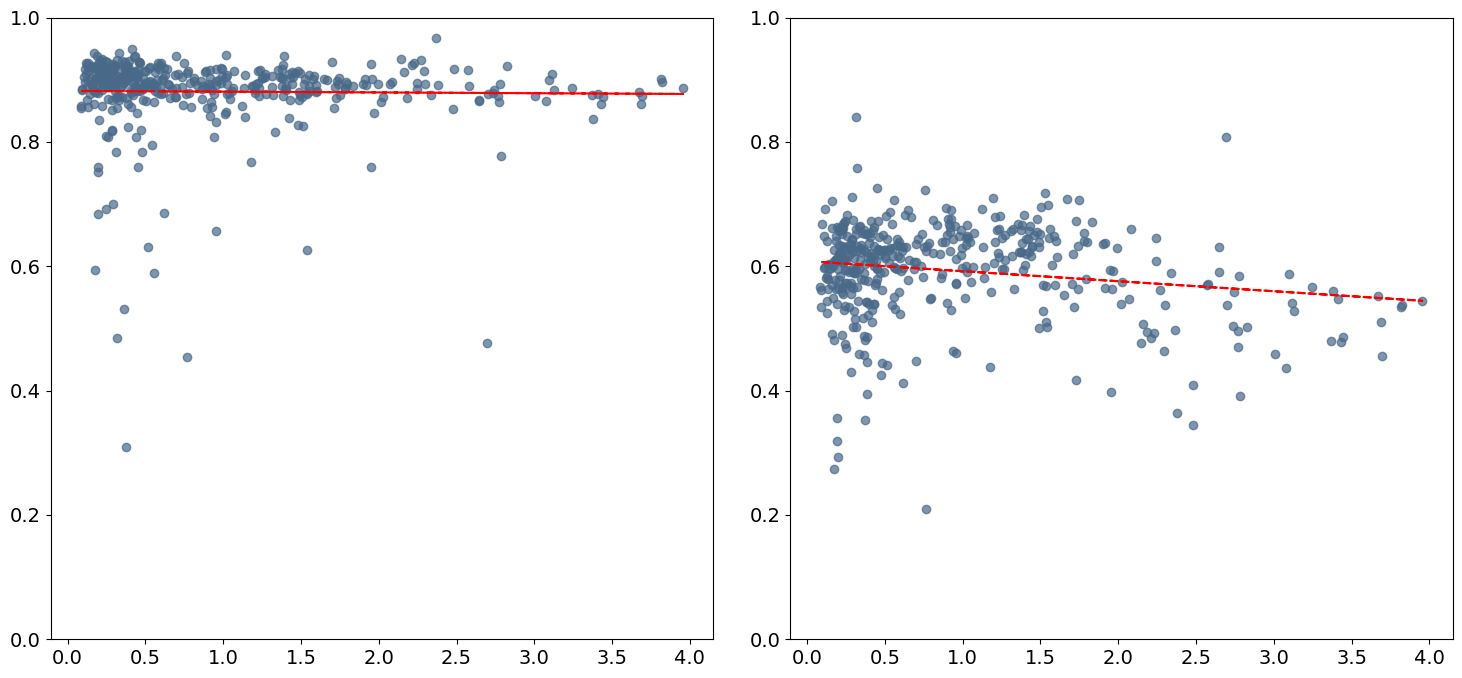

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
fig.tight_layout()
# total HOMA plots
for ax, col in zip(axs, ["inner_circuit", "pyrrole_avg"]):
    x = por_abs_np["total out of plane (exp)"]
    y = por_homa[col]
    a, b = np.polyfit(x, y, deg=1)
    print(col, "a =", a)
    ax.scatter(x, y, label="porphyrins", alpha=0.7)
    ax.plot(x, a * x + b, "r--")
    # ax.legend()
    ax.set_ylim(0, 1)
    # ax.set_xlabel("Total non planarity (A)")
    # ax.set_ylabel("HOMA")
    # ax.set_title(col.replace("_", " ").title())

plots of HOMA scores vs modes of non planarity

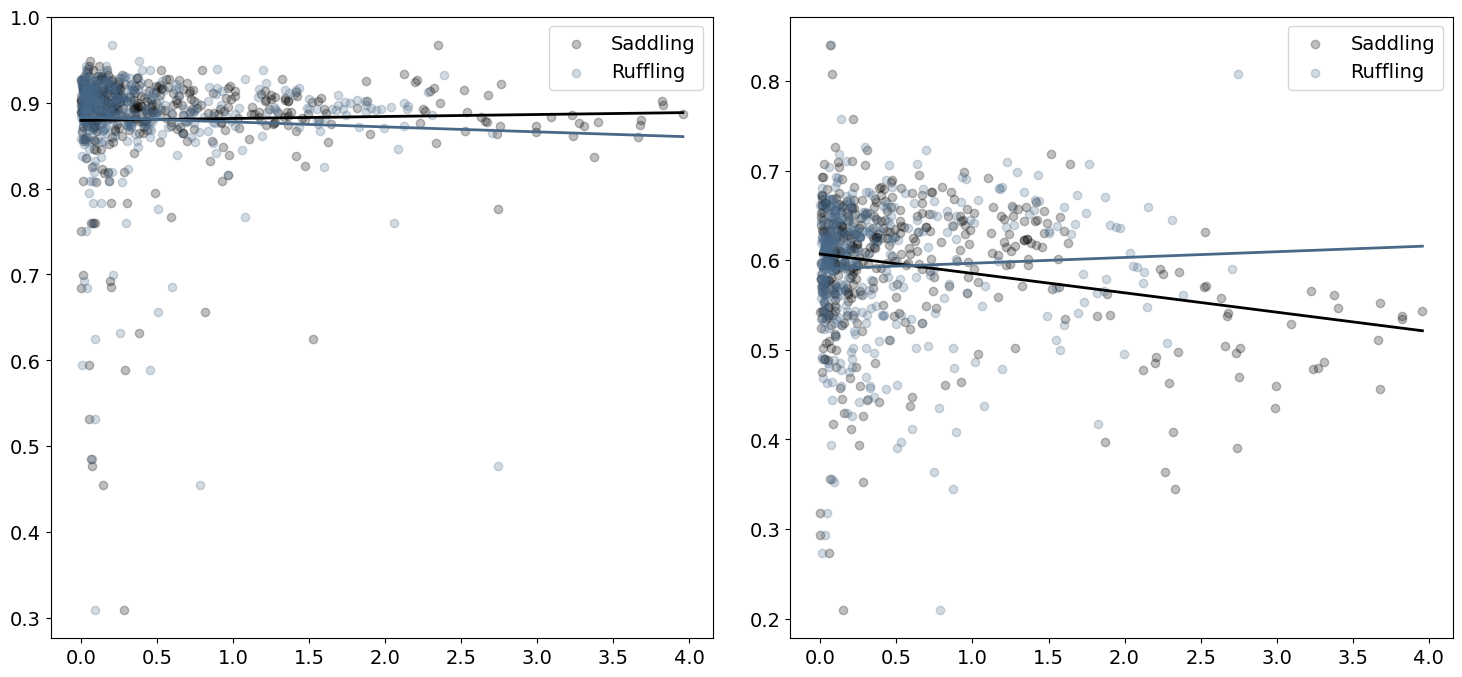

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
fig.tight_layout()
modes = ["saddling non planarity", "ruffling non planarity"]
homa_cols = ["inner_circuit", "pyrrole_avg"]
xmax = por_abs_np[modes].max().max()
xmin = 0
ajr = []
# ["#496989", "#58A399", "#A8CD9F", "#E2F4C5"]
colors = ["k", "#496989"]
for j in range(2):
    for i in range(len(modes)):
        col = homa_cols[j]
        sids = por_homa[por_homa[col] >= 0].index
        x = por_abs_np.loc[sids, modes[i]].abs()
        y = por_homa.loc[sids, col]
        label = modes[i].split()[0].title()
        axs[j].scatter(x, y, label=label, alpha=0.25, c=colors[i])
        a, b = np.polyfit(x, y, deg=1)
        axs[j].plot([0, xmax], [b, a * xmax + b], linewidth=2, color=colors[i])
        axs[j].legend()


In [24]:
por_abs_np

,doming non planarity,saddling non planarity,ruffling non planarity,wavingx non planarity,wavingy non planarity,propellering non planarity,doming2 non planarity,saddling2 non planarity,ruffling2 non planarity,wavingx2 non planarity,propellering2 non planarity,total out of plane (exp)
LAXDIX,-0.745227,0.367323,0.047459,0.030943,0.058674,-0.042114,0.276880,0.027848,-0.090665,0.022871,0.000541,0.605755
MUNJUA,0.509757,0.816680,0.504514,0.059908,-0.036354,0.028276,-0.610802,0.016554,0.162641,0.011365,0.034241,0.954832
AWIQEC,-0.067672,0.076722,-0.093592,0.018075,0.034307,0.010323,0.091507,0.002402,-0.045228,0.019485,-0.013383,0.130422
DIVVIO,0.066448,-0.670050,0.617241,0.054636,0.132578,0.013598,0.062274,-0.013853,-0.067597,0.023502,-0.000155,0.917355
TOBTUC,-0.009338,-0.529056,1.171301,0.077539,-0.022727,-0.010304,-0.124010,-0.125432,0.067423,-0.045700,-0.006852,1.238383
...,...,...,...,...,...,...,...,...,...,...,...,...
TEMFAS,-0.276100,-0.030613,0.011996,-0.019655,0.016348,0.005182,0.219727,0.003844,-0.061554,-0.017790,0.000516,0.084805
QUWTEJ,0.192658,0.491943,0.008755,-0.020277,0.113867,0.000726,-0.081536,0.053843,0.053878,0.058154,0.004099,0.524655
HOHZEK,-0.018592,1.250968,0.026723,-0.203428,0.016065,0.026286,-0.011655,0.109528,0.057459,-0.075913,-0.014851,1.268918
LAXDAP,-0.641238,0.405640,-0.049700,0.055994,0.048974,-0.060743,0.203780,-0.054359,-0.084963,0.008288,0.009909,0.612590


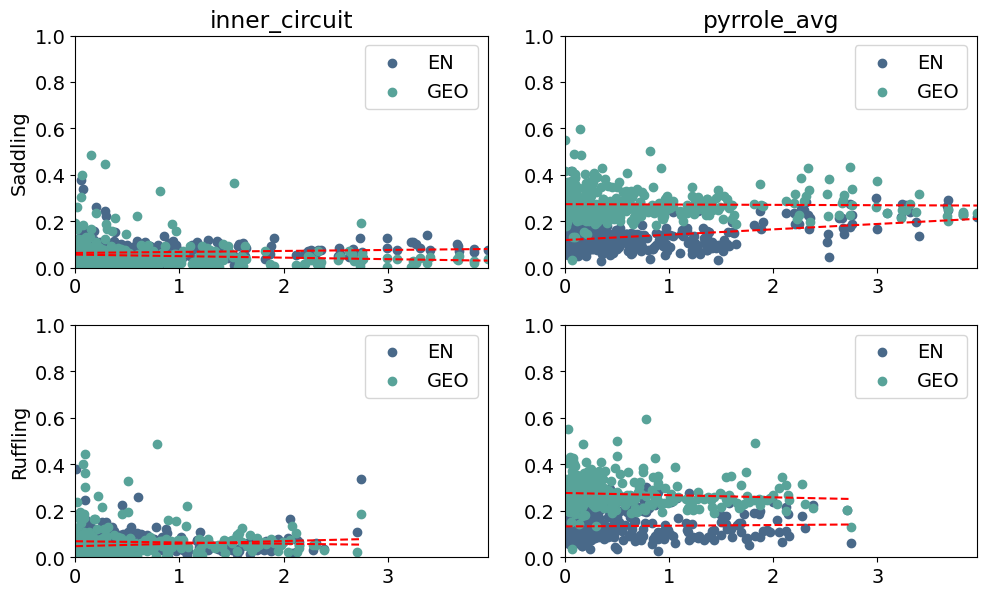

In [33]:
modes = ["saddling non planarity", "ruffling non planarity"]
homa_cols = ["inner_circuit", "pyrrole_avg"]
fig, axs = plt.subplots(ncols=len(homa_cols), nrows=len(modes), figsize=(10, 6))
fig.tight_layout()
xmax = por_abs_np[modes].max().max()
xmin = 0
ajr = []
for j in range(len(homa_cols)):
    for i in range(len(modes)):
        col = homa_cols[j]
        sids = por_homa[por_homa[col] >= 0].index
        x = por_abs_np.loc[sids, modes[i]].abs()
        if not "total out of plane" in modes[i]:
            scatter_plot(x, por_en.loc[sids, col], ax=axs[i, j], label="EN", add_fitted_line=True)
            scatter_plot(x, por_geo.loc[sids, col], ax=axs[i, j], label="GEO", add_fitted_line=True)
        else:
            scatter_plot(x, por_homa.loc[sids, col], ax=axs[i, j], label="HOMA", add_fitted_line=True)
        axs[i, j].legend()
        axs[i, j].set_xlim(0, xmax)
        axs[i, j].set_ylim(0, 1)
        if j == 0:
            axs[i, j].set_ylabel(modes[i].split()[0].title())
        if i == 0:
            axs[i, j].set_title(col)

# Model analysis

In [9]:
# utils

def plot_performance(df: pd.DataFrame, bar_width: float=0.6, bar_spacing: float=1, figsize=(15,8)):
    plt.figure(figsize=figsize)
    avg_cols = [c for c in df.columns if "avg" in c]
    ci_cols = [c for c in df.columns if "ci" in c]
    x = np.linspace(0, len(avg_cols) * bar_spacing + len(df) * len(avg_cols) * bar_width, len(avg_cols))
    feat_positions = lambda center: np.linspace(center - len(df) * bar_width / 2, center + len(df) * bar_width / 2 - bar_width, len(df))
    for i, feat in enumerate(df.index):
        pos = np.array([feat_positions(c)[i] for c in x])
        plt.bar(pos, df.loc[feat, avg_cols], width=bar_width, align="edge", label=feat)
        plt.errorbar(pos + bar_width / 2, df.loc[feat, avg_cols], df.loc[feat, ci_cols], linestyle="", ecolor="k")
    # fabulizing axis
    plt.xticks(x, [" ".join(c.split("_")[:-1]).title() for c in avg_cols])
    plt.ylabel("Test set MAE")
    plt.legend();

AGGREGATE_BY = {
    "cone_angles": {
        "meso": ["meso1", "meso2", "meso3", "meso4"],
        "beta": ["beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8"],
        "axial": ["coordination", "axial_angle"],
        "metal": ["metal_radius"]
    },
    "covalent_distances": {
        "meso-beta": ["meso1", "meso2", "meso3", "meso4", "beta2", "beta4", "beta6", "beta8"],
        "beta-beta": ["beta1", "beta3", "beta5", "beta7"],
        "axial": ["coordination", "axial_angle"],
        "metal": ["metal_radius"]
    },
    "vdw_distances": {
        "meso-beta": ["meso1", "meso2", "meso3", "meso4", "beta2", "beta4", "beta6", "beta8"],
        "beta-beta": ["beta1", "beta3", "beta5", "beta7"],
        "axial": ["coordination", "axial_angle"],
        "metal": ["metal_radius"]
    },
    "nn_distances": {
        "meso-beta": ["meso1", "meso2", "meso3", "meso4", "beta2", "beta4", "beta6", "beta8"],
        "beta-beta": ["beta1", "beta3", "beta5", "beta7"],
        "axial": ["coordination", "axial_angle"],
        "metal": ["metal_radius"]
    }
}

PROPERTY_NAME_MAPPER = {
    "inner_homa_avg": "Inner HOMA",
    "pyrrole_homa_avg": "Pyrrole HOMA",
    "total_out_of_plane_avg": "Total out of plane",
    "abs_ruffling_avg": "Absolute Ruffling",
    "abs_saddling_avg": "Absolute Saddling.",
    "abs_doming_avg": "Absolute Doming"
}

def get_influence(feat: str, aggregete: bool=True):
    df = pd.read_csv("../results/{}_influence.csv".format(feat), index_col=0)
    if not aggregete:
        return df
    df = df.transpose()
    for key, fields in AGGREGATE_BY[feat].items():
        df[key] = df[fields].sum(axis=1)
    return df[AGGREGATE_BY[feat].keys()].transpose()

feature selection

In [10]:
models_dir = "../models/"
fit_report = utils.read_performance_resutls(
    display_metric="test_mae", 
    display_targets=["inner_homa", "pyrrole_homa", "total_out_of_plane", "abs_ruffling", "abs_saddling", "abs_doming"],
    display_features=["cone_angles", "covalent_distances"],
    models_dir=models_dir,
    ci_alpha=0.05
)
fit_report

,cone_angles,covalent_distances
inner_homa_avg,0.035887,0.034455
inner_homa_ci,0.009338,0.008176
pyrrole_homa_avg,0.045400,0.044683
pyrrole_homa_ci,0.005465,0.004619
total_out_of_plane_avg,0.366941,0.362383
total_out_of_plane_ci,0.049745,0.052675
abs_ruffling_avg,0.323567,0.291831
abs_ruffling_ci,0.033978,0.032444
abs_saddling_avg,0.350048,0.341113
abs_saddling_ci,0.041076,0.042196


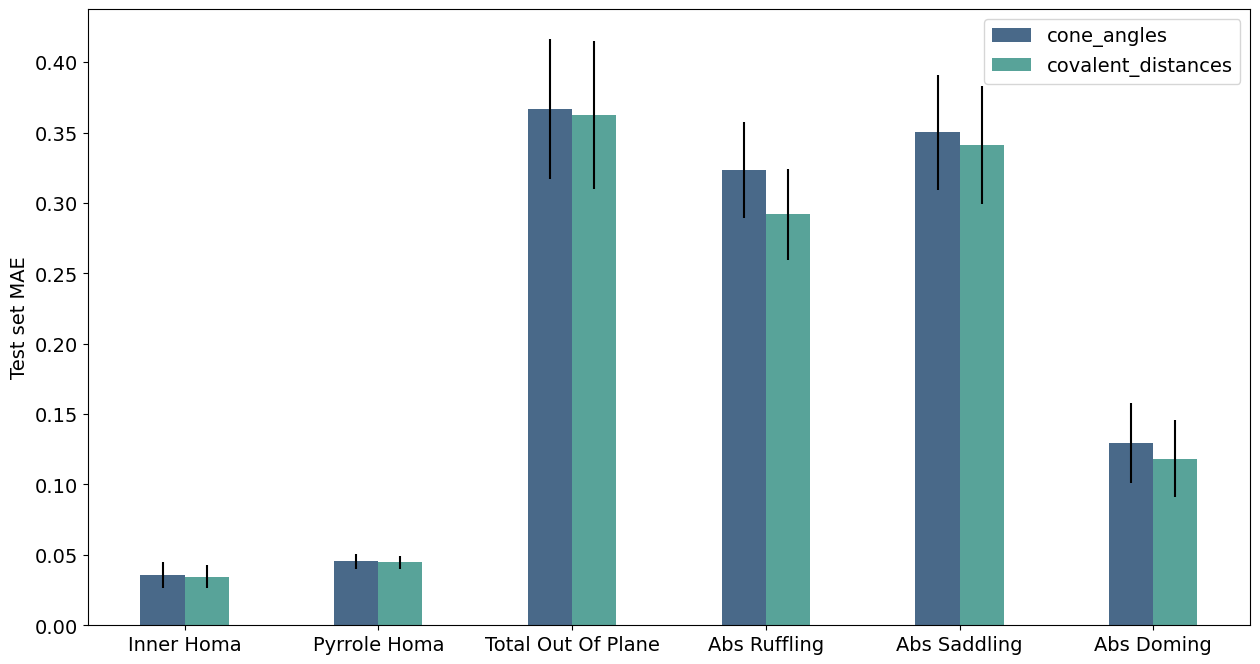

In [11]:
plot_performance(fit_report.transpose())

Export fit report data to excel

In [15]:
display_targets = ["inner_homa", "pyrrole_homa", "total_out_of_plane", "abs_ruffling", "abs_saddling", "abs_doming"]
display_features = ["cone_angles", "covalent_distances"]
display_metrics = ["train_mae", "test_mae", "train_rmse", "test_rmse", "train_r_squared", "test_r_squared"]
for feat in display_features:
    feat_df = None
    for metric in display_metrics:
        df = utils.read_performance_resutls(
            display_metric=metric, 
            display_targets=display_targets, 
            display_features=[feat], 
            models_dir=models_dir,
            ci_alpha=0.05
        )
        if feat_df is None:
            feat_df = df
            feat_df.columns = [metric]
            feat_df["target"] = [" ".join(s.split("_")[:-1]) for s in df.index]
            feat_df["parameter"] = [s.split("_")[-1] for s in df.index]
            feat_df = feat_df[["target", "parameter", metric]]
        else:
            feat_df[metric] = df[feat]
    feat_df.to_csv(feat + "_performance.csv")

Influence report

In [16]:
# read all influence data and save to results for quick reference
# NOTE: TAKES SOME TIME TO READ
from train_models import FEATURIZERS
for feat in FEATURIZERS:
    print(feat)
    df = utils.read_influence_results(models_dir=models_dir, ci_alpha=0.05, target_features=feat, feature_names=FEATURIZERS[feat].feature_names)
    df.to_csv("../results/{}_influence.csv".format(feat))

cone_angles
vdw_distances
covalent_distances
nn_distances
reduced_vdw_distances
reduced_cone_angles
angles_and_distances


/tmp/ipykernel_3493/1015745987.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=cum[i] + value/2, y=i, s=text, va='center', ha='center', color='white', fontdict={"fontsize": 16})


,meso-beta,beta-beta,axial,metal
total_out_of_plane_avg,0.619629,0.163749,0.134449,0.082173
pyrrole_homa_avg,0.317271,0.348520,0.296144,0.038065
inner_homa_avg,0.364242,0.323722,0.284675,0.027361
abs_saddling_avg,0.739946,0.155236,0.078626,0.026193
abs_ruffling_avg,0.350587,0.159340,0.314167,0.175907
abs_doming_avg,0.500258,0.204702,0.179711,0.115329


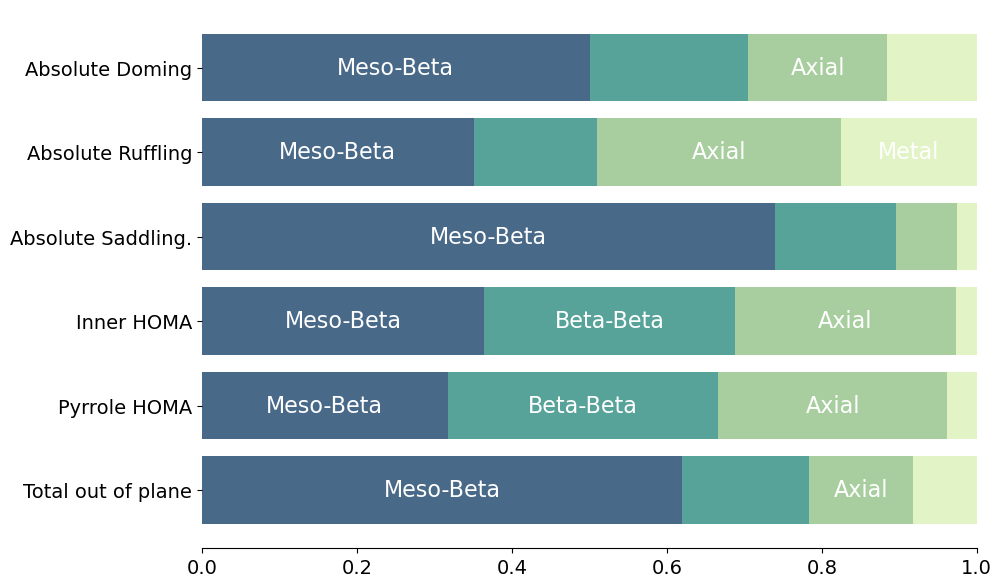

In [26]:
df = get_influence("covalent_distances")
# df = get_influence("cone_angles")
df = df[[c for c in df.columns if c.endswith("_avg")]]
df = df.transpose()
df = df.sort_index(ascending=False)
cum = np.zeros_like(df.iloc[:, 0])
plt.figure(figsize=(10, 7))
for col in df.columns:
    plt.barh(y=range(len(df)), width=df[col], left=cum, height=0.8)
    for i in range(len(df)):
        value = df[col].iloc[i]
        if value > len(col) * 0.025:
            text = "-".join([s.title() for s in col.split("-")])
            plt.text(x=cum[i] + value/2, y=i, s=text, va='center', ha='center', color='white', fontdict={"fontsize": 16})
    cum += df[col]
# fabulizing plot
plt.yticks(range(len(df)), [PROPERTY_NAME_MAPPER[x] for x in df.index])
plt.xlim(0, 1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
df

export influence report to excel

In [30]:
get_influence("covalent_distances").transpose().to_csv("covalent_distances_influence.csv")
get_influence("cone_angles").transpose().to_csv("cone_angle_influence.csv")

In [4]:
from train_models import FEATURIZERS, REGRESSION_TARGETS, reduced_cone_angles, FunctionFeaturizer, axial_features, SubstituentPropertyFeaturizer, MACROCYCLE_POSITIONS, CLASSIFICATION_TARGETS, augment_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [5]:
def reduced_distances_helper(pname, session, sid):
    feat = SubstituentPropertyFeaturizer(pname, None, MACROCYCLE_POSITIONS[0], navalue=None)
    df = feat.featurize(session, [sid])
    beta_beta = df[["beta1", "beta3", "beta5", "beta7"]].values
    # beta_beta = list(filter(lambda x: 0.2 > x or x > 0.3, beta_beta[0]))
    # if len(beta_beta) == 0:
    #     beta_beta = [0.25]
    beta_meso = df[["meso" + str(i + 1) for i in range(4)] + ["beta2", "beta4", "beta6", "beta8"]].values
    # beta_meso = list(filter(lambda x: -0.2 < x or x < -0.3, beta_meso[0]))
    # if len(beta_meso) == 0:
    #     beta_meso = [-0.25]
    return [np.mean(beta_beta), np.mean(beta_meso)]

def reduced_distances(pname):
    return lambda session, sid: reduced_distances_helper(pname, session, sid)

def augment_data(X, y):
    new_X = []
    new_y = []
    prefixes = list(set([x.split("_")[0] for x in X.columns if any([pos in x and not pos == x for pos in MACROCYCLE_POSITIONS[0]])]))
    for macro_pos in MACROCYCLE_POSITIONS:
        if len(prefixes) > 0:
            pos = []
            for prefix in prefixes:
                pos += [prefix + "_" + x for x in macro_pos]
            macro_pos = pos
        for i in range(len(y)):
            idxs = macro_pos + X.columns[len(macro_pos):].tolist()
            equiv = X.iloc[i, :][idxs].to_numpy()
            new_X.append(equiv)
            new_y.append(y.iloc[i, :])
    return pd.DataFrame(new_X), pd.DataFrame(new_y)

def mixed_angle_distance(session, sid):
    feat = SubstituentPropertyFeaturizer("covalent nn dist", None, MACROCYCLE_POSITIONS[0], navalue=None)
    ajr = feat.featurize(session, [sid]).values[0].tolist()
    feat = SubstituentPropertyFeaturizer("cone angle", None, MACROCYCLE_POSITIONS[0], navalue=-1)
    ajr += feat.featurize(session, [sid]).values[0].tolist()
    return ajr


In [46]:
# featurizer = FunctionFeaturizer(["beta-beta", "beta-meso"], reduced_distances("vdw nn dist"), None) + FunctionFeaturizer(["coordination", "axial_angle"], axial_features, -1) +\
#                 FunctionFeaturizer("metal_radius", metal_radius, navalue=None)
# featurizer = FunctionFeaturizer(["beta-beta", "beta-meso"], reduced_distances("vdw nn dist"), None)
featurizer = FunctionFeaturizer(["dist_" + x for x in MACROCYCLE_POSITIONS[0]] + ["angle_" + x for x in MACROCYCLE_POSITIONS[0]], mixed_angle_distance, -1) +\
          FunctionFeaturizer(["coordination", "axial_angle"], axial_features, -1) + FunctionFeaturizer("metal_radius", metal_radius, navalue=None)
# featurizer = SubstituentPropertyFeaturizer("covalent nn dist", None, MACROCYCLE_POSITIONS[0], navalue=None) +\
#              SubstituentPropertyFeaturizer("cone angle", None, MACROCYCLE_POSITIONS[0], navalue=-1) +\
#              FunctionFeaturizer(["coordination", "axial_angle"], axial_features, -1) + FunctionFeaturizer("metal_radius", metal_radius, navalue=None)
# featurizer = SubstituentPropertyFeaturizer("cone angle", None, MACROCYCLE_POSITIONS[0], navalue=-1) +\
#              SubstituentPropertyFeaturizer("cone angle", None, ["axial1", "axial2"], navalue=-1) + FunctionFeaturizer("metal_radius", metal_radius, navalue=None)
# featurizer = FEATURIZERS["cone_angles"]
target = REGRESSION_TARGETS["inner_homa"]
X = featurizer.featurize(session, por_sids)
y = target.featurize(session, por_sids)
X

,dist_meso1,dist_beta1,dist_beta2,dist_meso2,dist_beta3,dist_beta4,dist_meso3,dist_beta5,dist_beta6,dist_meso4,...,angle_beta4,angle_meso3,angle_beta5,angle_beta6,angle_meso4,angle_beta7,angle_beta8,coordination,axial_angle,metal_radius
LAXDIX,1.439993,1.542052,1.586067,1.439993,1.542335,1.586067,1.439993,1.562633,1.586067,1.439993,...,51.422813,19.046482,52.061906,51.881612,19.029598,51.926050,51.479606,6.0,24.974190,2.30
MUNJUA,1.434035,1.804637,0.941257,1.074050,1.808708,1.434670,1.432998,1.804137,1.857943,1.857943,...,19.025515,56.726645,18.948169,19.048044,19.076140,19.084912,19.138085,4.0,-1.000000,2.00
AWIQEC,1.431442,1.805914,1.432700,1.431442,1.804794,1.431434,1.430318,1.805790,1.432700,1.431442,...,19.016041,56.530847,19.067580,19.061032,56.332022,19.080319,19.070561,4.0,-1.000000,2.05
DIVVIO,1.431241,1.805058,1.428387,1.436162,1.804117,1.426208,1.436959,1.805330,1.434471,1.429853,...,19.034288,60.355752,19.032903,19.045348,60.693586,19.060684,19.066380,5.0,65.586203,2.00
TOBTUC,1.432998,1.804789,1.434670,1.432998,1.804429,1.434670,1.432998,1.810693,1.434289,1.434035,...,19.045111,56.225362,19.037371,19.050616,56.305363,19.037486,19.064506,6.0,33.226581,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEMFAS,1.439993,1.541903,1.586067,1.439993,1.541989,1.586067,1.440015,1.542094,1.586067,1.440015,...,51.731386,19.477004,51.781867,52.973691,19.475864,51.686575,50.792485,6.0,32.765124,2.05
QUWTEJ,1.431736,1.809996,1.433414,1.433390,1.808161,1.433414,1.433390,1.804076,1.434471,1.429853,...,19.035251,60.494730,19.039607,19.047131,60.632914,19.048557,19.043308,6.0,59.327548,2.05
HOHZEK,1.433560,1.810056,1.429991,1.433216,1.807212,1.430258,1.433560,1.805651,1.427606,1.428681,...,19.453732,55.750424,19.457123,19.444933,55.112306,19.454214,19.464540,5.0,42.767979,2.00
LAXDAP,1.439993,1.555017,1.586067,1.439993,1.542302,1.586067,1.439993,1.542088,1.586067,1.439993,...,52.473130,19.125742,52.055448,52.296490,19.137676,51.202296,52.776074,6.0,24.428671,2.30


In [47]:
model = RandomForestRegressor(n_estimators=100);
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2);
# xtrain, ytrain = augment_data(xtrain, ytrain)
# xtest, ytest = augment_data(xtest, ytest)
print(len(ytrain), len(ytest))
model.fit(xtrain, ytrain);

340 85


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

Text(0.5, 1.0, 'Test')

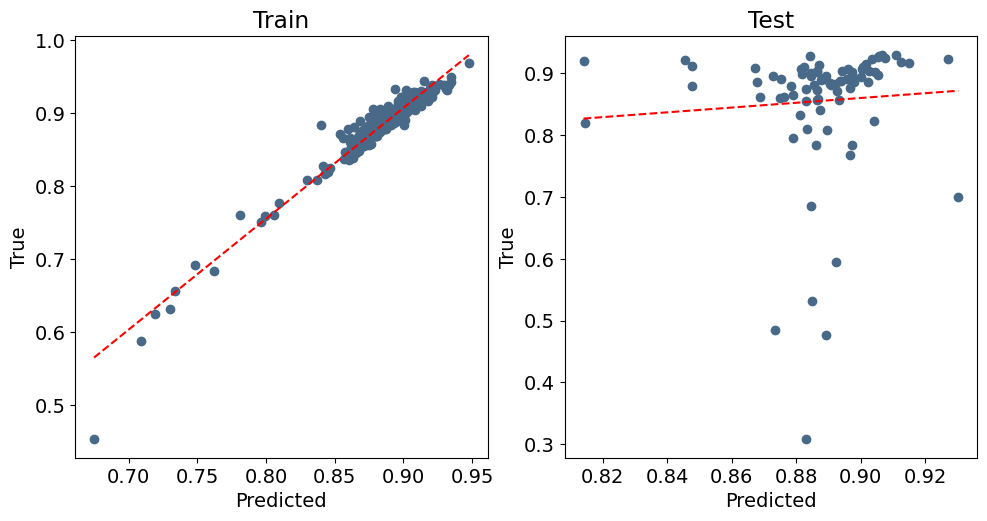

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout()
scatter_plot(model.predict(xtrain).flatten(), ytrain, xname="Predicted", ax=axs[0], yname="True", add_fitted_line=True)
axs[0].set_title("Train")
scatter_plot(model.predict(xtest).flatten(), ytest, xname="Predicted", ax=axs[1], yname="True", add_fitted_line=True)
axs[1].set_title("Test")


In [49]:
print("R^2", utils.calc_r_squared(model.predict(xtest.values).flatten(), ytest.values))
print("MAE", utils.calc_mae(model.predict(xtest.values).flatten(), ytest.values))

R^2 [0.00440816]
MAE [0.05126679]


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
df = pd.DataFrame({"A": [1, 2], "B": [3, 4]})
df.columns = ["A", "A"]
df

,A,A
0,1,3
1,2,4


In [154]:
df.iloc[[0, 0], :]

,A,A
0,1,3
0,1,3


240 60


/tmp/ipykernel_17283/1160185584.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain, ytrain);


Text(0.5, 1.0, 'Test')

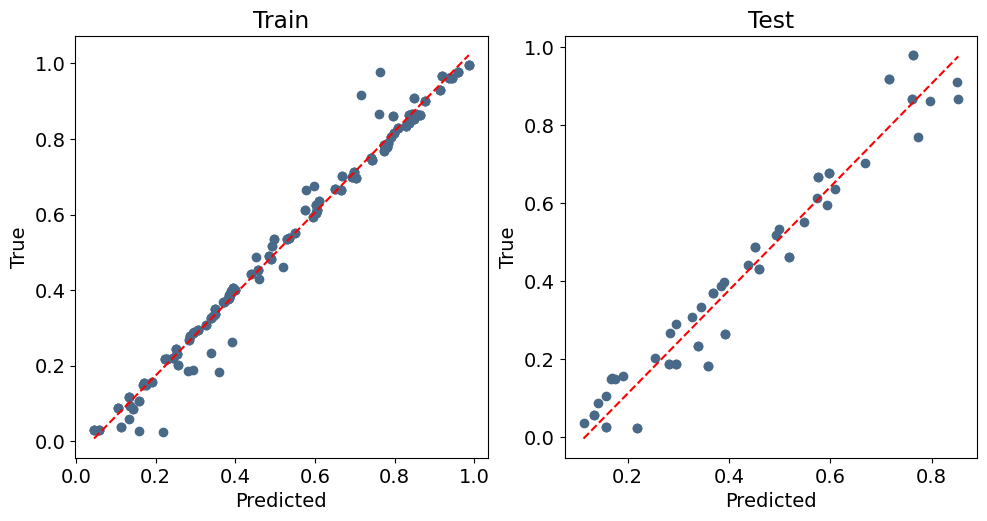

In [230]:
X = pd.DataFrame(np.random.rand(100, 5))
y = pd.DataFrame(np.random.rand(100))
X = X.loc[3 * X.index.tolist(), :]
y = y.loc[X.index, :]
model = RandomForestRegressor(n_estimators=1000);
xtrain, xtest, ytrain, ytest = train_test_split(X.values, y.values, test_size=0.2);
print(len(ytrain), len(ytest))
model.fit(xtrain, ytrain);
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout()
scatter_plot(model.predict(xtrain).flatten(), ytrain, xname="Predicted", ax=axs[0], yname="True", add_fitted_line=True)
axs[0].set_title("Train")
scatter_plot(model.predict(xtest).flatten(), ytest, xname="Predicted", ax=axs[1], yname="True", add_fitted_line=True)
axs[1].set_title("Test")
